In [263]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [264]:
train=torch.load('lorenz_test.pt')

In [265]:
training_data=train['data']
time_steps=training_data.shape[1]

In [266]:
train['data'].shape

torch.Size([256, 1024, 3])

Dimensions of x(t): (1024, 3)


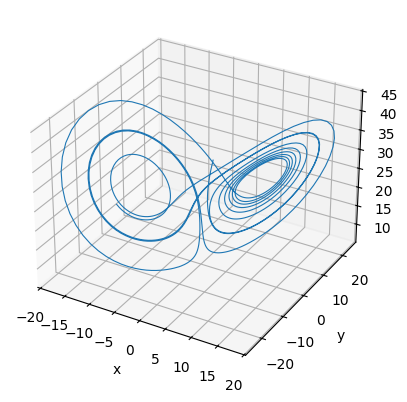

In [267]:
traj = train['data'][0,:,:].numpy()  
print(f"Dimensions of x(t): {traj.shape}")

# Plot 3D trajectory
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(traj[:, 0], traj[:, 1], traj[:, 2], lw=0.8)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.show()

In [268]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.bandwidth=3
        self.koopman_dimension=32
        self.koopman_matrix=torch.diagflat(torch.randn(self.koopman_dimension,requires_grad=True))
        for i in range(self.bandwidth):
            i+=1
            self.koopman_matrix += torch.diagflat(torch.randn(self.koopman_dimension-i,requires_grad=True),i)
            self.koopman_matrix += torch.diagflat(torch.randn(self.koopman_dimension-i,requires_grad=True),-i)
        self.koopman_matrix=self.koopman_matrix/(self.koopman_dimension)**0.5
        self.encode = nn.Sequential(
            nn.Linear(3,500),
            nn.Linear(500,32),
            nn.LayerNorm(32)
        )
        self.decode = nn.Sequential(
            nn.Linear(32,500),
            nn.Linear(500,3)
        )
        self.encode_decode = nn.Sequential(
            self.encode,
            self.decode
        )
        self.koopman_dynamics=torch.stack([torch.linalg.matrix_power(
            self.koopman_matrix,step
        ) for step in range(time_steps)])

    def forward(self,x):
        x=self.encode(x)
        x=self.evolve_koopman(x)
        x=self.decode(x)
        return x

    def evolve_koopman(self,x,steps=1):
        Kj=torch.linalg.matrix_power(self.koopman_matrix,steps)
        return torch.einsum('ij,...j->...i',Kj,x)

    def evolve_state(self,x,steps=1):
        x=self.encode(x)
        x=self.evolve_koopman(x,steps)
        x=self.decode(x)
        return x

model = Autoencoder()

In [269]:
print(
    model.koopman_dynamics.shape,
    model.encode(training_data)[0,0].shape,
    torch.einsum(
        'ijk,k->ij',
        model.koopman_dynamics,
        model.encode(training_data[0,0])
    )[3],
    torch.matrix_power(model.koopman_matrix,3)@(model.encode(training_data[0,0]))
)


torch.Size([1024, 32, 32]) torch.Size([32]) tensor([-0.1509, -0.0543, -0.0638,  0.0709,  0.0521, -0.0543, -0.1062, -0.0321,
        -0.0051, -0.0345,  0.0688, -0.0253,  0.0160, -0.0455, -0.0139,  0.0362,
        -0.0085, -0.0140, -0.0310, -0.1259, -0.0402,  0.1020,  0.0333,  0.0139,
         0.0438, -0.2707,  0.1693, -0.0185,  0.0335,  0.0761, -0.0744, -0.0715],
       grad_fn=<SelectBackward0>) tensor([-0.1509, -0.0543, -0.0638,  0.0709,  0.0521, -0.0543, -0.1062, -0.0321,
        -0.0051, -0.0345,  0.0688, -0.0253,  0.0160, -0.0455, -0.0139,  0.0362,
        -0.0085, -0.0140, -0.0310, -0.1259, -0.0402,  0.1020,  0.0333,  0.0139,
         0.0438, -0.2707,  0.1693, -0.0185,  0.0335,  0.0761, -0.0744, -0.0715],
       grad_fn=<MvBackward0>)


In [270]:
print(training_data.shape)
print(torch.linalg.matrix_power(mat,2))
print(mat @ mat)

torch.Size([256, 1024, 3])
tensor([[ 2.4842,  3.0099,  1.5004,  0.0688],
        [ 0.9397,  2.3994,  0.1965, -0.2143],
        [ 2.7500,  6.5327,  1.0483,  3.0191],
        [ 3.4854,  1.5761, -0.2470,  0.9227]])
tensor([[ 2.4842,  3.0099,  1.5004,  0.0688],
        [ 0.9397,  2.3994,  0.1965, -0.2143],
        [ 2.7500,  6.5327,  1.0483,  3.0191],
        [ 3.4854,  1.5761, -0.2470,  0.9227]])


In [271]:
print(
model.encode(training_data).shape,
model.encode(training_data[:,0,:]).shape,
model.encode(training_data).shape
)

torch.einsum(
    'ijk,rk->rik',
    model.koopman_dynamics,
    model.encode(training_data[:,0,:])
).shape


torch.Size([256, 1024, 32]) torch.Size([256, 32]) torch.Size([256, 1024, 32])


torch.Size([256, 1024, 32])

In [272]:
training_data=train['data']
model=Autoencoder()

autoencoding=model.decode(model.encode(training_data))
dynamical_evolution=model.decode(
    torch.einsum(
        'ijk,rk->rik',
        model.koopman_dynamics,
        model.encode(training_data[:,0,:])
    )
)
loss_0 = nn.MSELoss()
loss_1 = nn.MSELoss()
loss_2 = (model.koopman_matrix**2).sum()
loss = sum(
    [loss_0(training_data,autoencoding),
    loss_1(training_data,dynamical_evolution),
    loss_2]
)
loss

tensor(526.8297, grad_fn=<AddBackward0>)

In [273]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

# --- Hyperparameters (change if needed) ---
batch_size = 32
epochs = 100
lr = 1e-3
device = torch.device("mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu"))
model.to(device)
training_data = training_data.to(device)
model.koopman_dynamics = model.koopman_dynamics.to(device)
model.koopman_matrix = model.koopman_matrix.to(device)

#training_data: tensor shape [N_trajectories, N_times, D] e.g. [256, 1024, 3]
model.to(device)
training_data = training_data.to(device)

dataset = TensorDataset(training_data)           # single-tensor dataset
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=False)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)   
mse = nn.MSELoss()

for epoch in range(1, epochs + 1):
    model.train()
    total_loss = 0.0
    total_items = 0
    for (batch,) in loader:
        # batch shape: [B, T, D]
        batch = batch.to(device)

        optimizer.zero_grad()

        # reconstruction (autoencoding)
        reconstruction = model.decode(model.encode(batch))  
        
        x0 = model.encode(batch[:, 0, :])  # shape [B, latent_dim] 
        latent_dynamics = torch.einsum('ijk,rk->rik', model.koopman_dynamics, x0)  # keep same einsum convention
        dynamical_evolution = model.decode(latent_dynamics)

        loss_0 = mse(reconstruction, batch)
        loss_1 = mse(dynamical_evolution, batch)
        loss_2 = (model.koopman_matrix ** 2).sum()     

        loss = loss_0 + loss_1 + loss_2
        loss.backward()
        optimizer.step()

        bsz = batch.shape[0]
        total_loss += loss.item() * bsz
        total_items += bsz

    avg_loss = total_loss / total_items
    if epoch % 10 == 0 or epoch == 1:
        print(f"Epoch {epoch:4d}  avg_loss={avg_loss:.6f}")


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [ ]:
model(training_data).shape

In [ ]:
mat=torch.randn(4,4)
tens=torch.randn(2,3,4)
print(torch.einsum('ij,...j->...i',mat,tens))
print(torch.einsum('ij,lmj->lmi',mat,tens))

In [ ]:
random_input=torch.randn(3)
model(random_input)
loss_0 = nn.MSELoss()
loss_0(random_input,model(random_input))

In [ ]:
training_data=train['data']
print(training_data.reshape(3,1024,256).shape)
model.encoder(training_data).shape

In [ ]:
random_vector=torch.randn(5,requires_grad=True)
torch.diagflat(random_vector)+torch.diagflat(random_vector[1:],1)+torch.diagflat(random_vector[1:],-1)

In [ ]:
Autoencoder().bandwidth
torch.diagflat(torch.randn(32-2),2)

In [ ]:
Autoencoder().koopman_matrix[:6,:6]